## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio
import os

## Constants and hyperparameters

In [2]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

## Loading the MNIST dataset and preprocessing it

In [3]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


2022-04-01 17:03:53.372113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 17:03:53.376259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 17:03:53.376983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 17:03:53.406514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [4]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


## Creating the discriminator and generator





In [5]:
def downsample(x, filters, kernel_size, strides, padding):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    return x


def get_discriminator(image_size, discriminator_in_channels):
    
    inp = keras.layers.Input((image_size, image_size, discriminator_in_channels))
    
    x = downsample(inp, filters=64, kernel_size=3, strides=2, padding="same")
    x = downsample(x, filters=128, kernel_size=3, strides=2, padding="same")
    
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(1)(x)
    
    model = keras.models.Model(inputs=inp, outputs=x)
    return model

In [6]:
discriminator = get_discriminator(image_size, discriminator_in_channels)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 11)]      0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        6400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                             

In [7]:
def upsample(x, filters, kernel_size, strides, padding):
    x = layers.Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    return x


def get_generator(generator_in_channels, num_channels):
    
    inp = keras.layers.Input((100 + 10,))
    x = layers.Dense(7 * 7 * generator_in_channels)(inp)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((7, 7, generator_in_channels))(x)

    x = upsample(x, filters=128, kernel_size=4, strides=2, padding='same')
    x = upsample(x, filters=128, kernel_size=4, strides=2, padding='same')
    
    x = layers.Conv2D(num_channels, kernel_size=7, padding="same", activation="sigmoid")(x)
    
    model = keras.models.Model(inputs=inp, outputs=x)
    
    return model


In [8]:
generator = get_generator(generator_in_channels, num_channels)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 138)]             0         
                                                                 
 dense_1 (Dense)             (None, 6762)              939918    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6762)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 138)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      282752    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           

## Loss

In [9]:
bce_obj = keras.losses.BinaryCrossentropy(from_logits=True)
def loss_fn(labels, predictions):
    loss = bce_obj(labels, predictions)
    return loss


In [10]:
d_optimizer=keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer=keras.optimizers.Adam(learning_rate=0.0003)

## Checkpoints

In [11]:
checkpoint_dir = '/media/aivn24/partition2/Khoa/AI2021/GAN/SLIDE/CODE_THAY/condtional_CGAN_CKPT'
# chọn đường dẫn lưu checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(d_optimizer=d_optimizer,
                                 g_optimizer=g_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Train

In [12]:
def generated_image(generator, latent_dim):
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    one_hot_labels = keras.utils.to_categorical(labels, 10)
    
    random_latent_vectors = tf.random.normal(shape=(10, latent_dim))
    random_vector_labels = tf.concat(
        [random_latent_vectors, one_hot_labels], axis=1)
    generated_images = generator(random_vector_labels)
    generated_images.numpy()
    show_list = []
    for i in range(10):
        show_list.append(np.squeeze(generated_images[i]))
    plt.figure(figsize=(20, 20))
    plt.imshow(np.concatenate(show_list, axis=1), cmap="Greys_r")
    plt.show()

In [19]:
@tf.function(experimental_relax_shapes=True)
def train_step(data):
    # Unpack the data.
    real_images, one_hot_labels = data

    # Add dummy dimensions to the labels so that they can be concatenated with
    # the images. This is for the discriminator.
    image_one_hot_labels = one_hot_labels[:, :, None, None]
    image_one_hot_labels = tf.repeat(image_one_hot_labels, 
                                     repeats=[image_size * image_size])
    image_one_hot_labels = tf.reshape(image_one_hot_labels, 
                                      (-1, image_size, image_size, num_classes))

    # Sample random points in the latent space and concatenate the labels.
    # This is for the generator.
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

    # Decode the noise (guided by labels) to fake images.
    generated_images = generator(random_vector_labels)

    # Combine them with real images. Note that we are concatenating the labels
    # with these images here.
    fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
    real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
    combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

    # Assemble labels discriminating real from fake images.
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

    # Train the discriminator.
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    
    
    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

    # Assemble labels that say "all real images".
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator 
    with tf.GradientTape() as tape:
        fake_images = generator(random_vector_labels)
        fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
        predictions = discriminator(fake_image_and_labels)
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

    return d_loss, g_loss


In [20]:
def fit(train_ds, epochs):
    for epoch in range(epochs):
        for data in train_ds:                      
            d_loss, g_loss = train_step(data)
        
        checkpoint.save(file_prefix = checkpoint_prefix)
        generated_image(generator, latent_dim)
        print('epoch: {} d_loss {}  g_loss: {}'.format(epoch, d_loss, g_loss))


Epoch 1/50


2022-04-01 12:03:55.198520: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-01 12:03:55.456607: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


1094/1094 [==============================] - ETA: 0s - g_loss: 1.4946 - d_loss: 0.4100

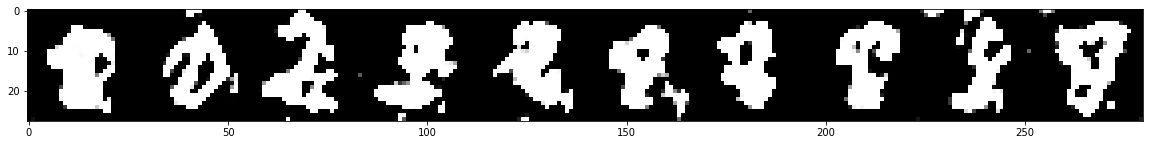

1094/1094 [==============================] - 17s 14ms/step - g_loss: 1.4946 - d_loss: 0.4100
Epoch 2/50
1094/1094 [==============================] - ETA: 0s - g_loss: 1.3577 - d_loss: 0.4760

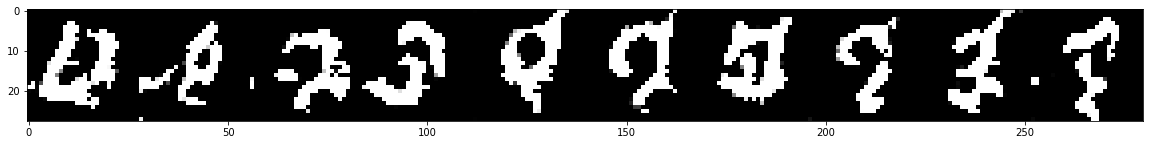

1094/1094 [==============================] - 17s 16ms/step - g_loss: 1.3577 - d_loss: 0.4760
Epoch 3/50
1094/1094 [==============================] - ETA: 0s - g_loss: 1.6153 - d_loss: 0.3919

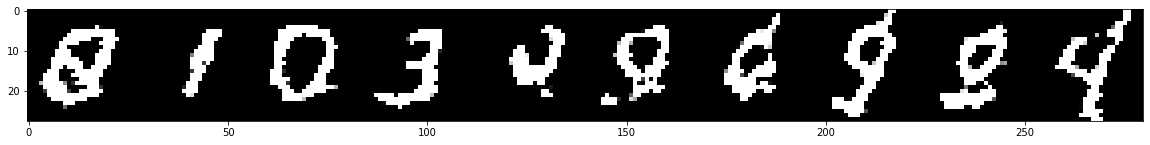

1094/1094 [==============================] - 17s 15ms/step - g_loss: 1.6154 - d_loss: 0.3919
Epoch 4/50
1094/1094 [==============================] - ETA: 0s - g_loss: 2.0900 - d_loss: 0.2567

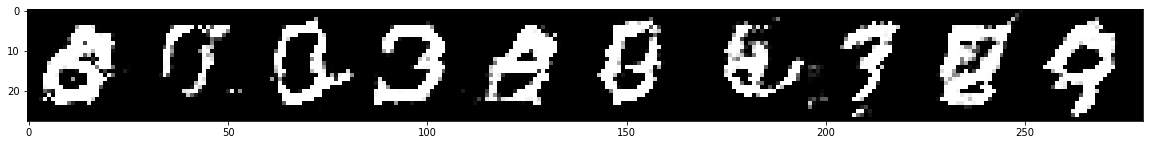

1094/1094 [==============================] - 18s 16ms/step - g_loss: 2.0901 - d_loss: 0.2566
Epoch 5/50
1094/1094 [==============================] - ETA: 0s - g_loss: 1.4565 - d_loss: 0.5068

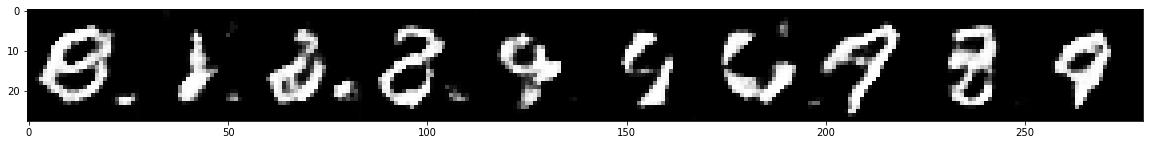

1094/1094 [==============================] - 17s 16ms/step - g_loss: 1.4562 - d_loss: 0.5069
Epoch 6/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 1.0512 - d_loss: 0.6097

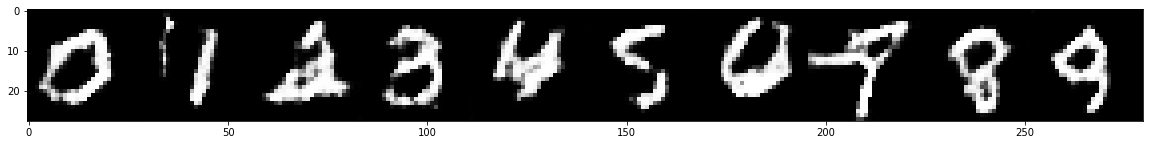

1094/1094 [==============================] - 18s 16ms/step - g_loss: 1.0511 - d_loss: 0.6097
Epoch 7/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.8902 - d_loss: 0.6537

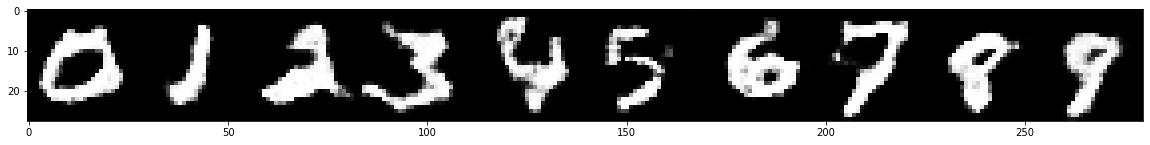

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8902 - d_loss: 0.6537
Epoch 8/50
1094/1094 [==============================] - ETA: 0s - g_loss: 0.8715 - d_loss: 0.6616

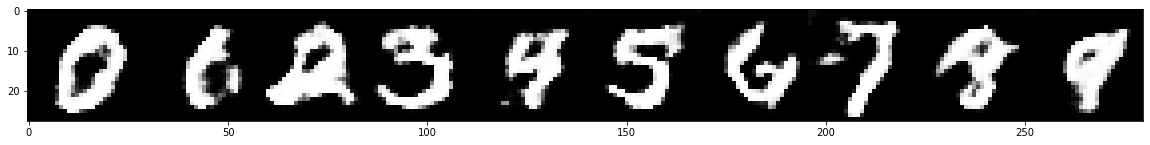

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8715 - d_loss: 0.6616
Epoch 9/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.8038 - d_loss: 0.6794

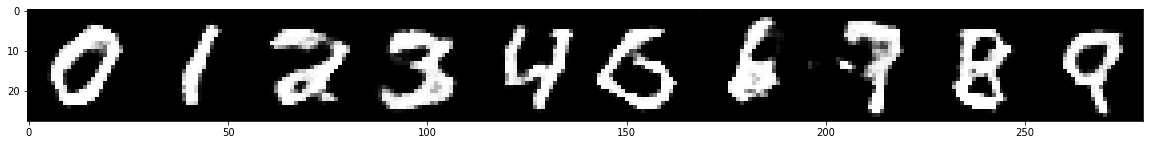

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8038 - d_loss: 0.6794
Epoch 10/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.7797 - d_loss: 0.6845

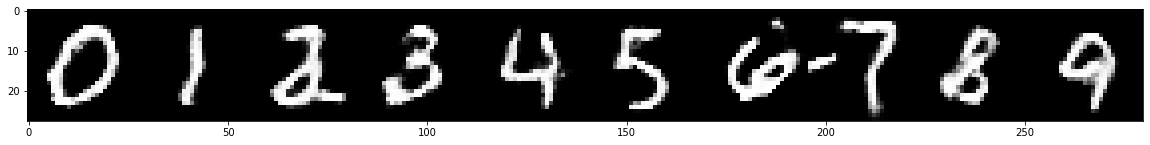

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7797 - d_loss: 0.6845
Epoch 11/50
1091/1094 [============================>.] - ETA: 0s - g_loss: 0.7741 - d_loss: 0.6809

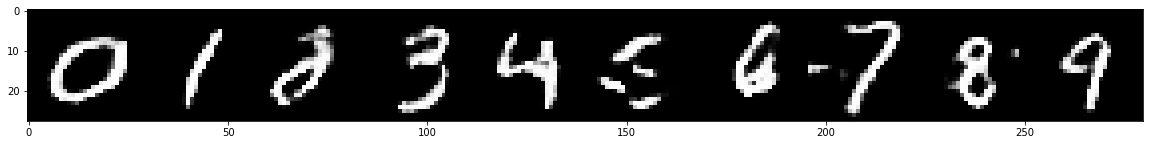

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7741 - d_loss: 0.6809
Epoch 12/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7582 - d_loss: 0.6868

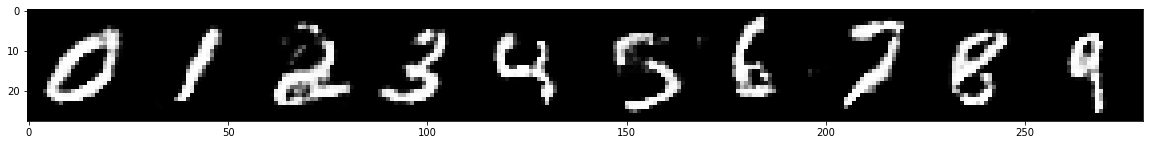

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7582 - d_loss: 0.6868
Epoch 13/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.7666 - d_loss: 0.6794

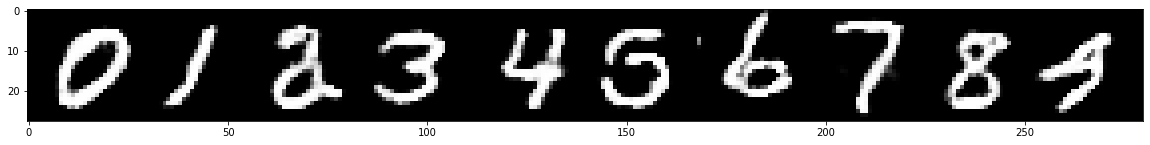

1094/1094 [==============================] - 17s 16ms/step - g_loss: 0.7666 - d_loss: 0.6794
Epoch 14/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7526 - d_loss: 0.6830

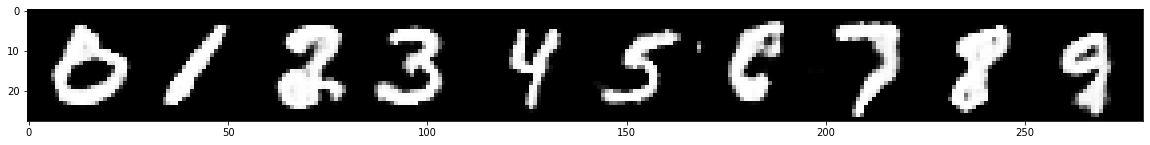

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7526 - d_loss: 0.6830
Epoch 15/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7669 - d_loss: 0.6750

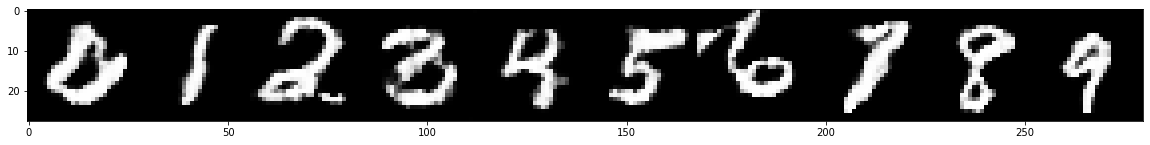

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7669 - d_loss: 0.6750
Epoch 16/50
1094/1094 [==============================] - ETA: 0s - g_loss: 0.7587 - d_loss: 0.6756

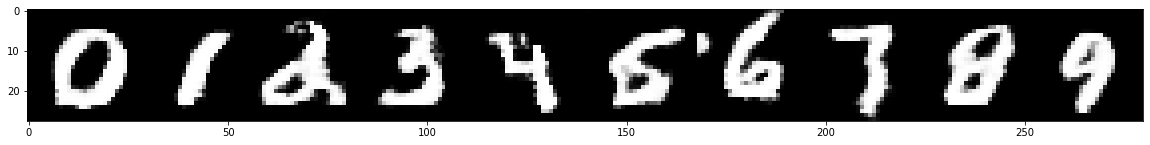

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7587 - d_loss: 0.6756
Epoch 17/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7717 - d_loss: 0.6733

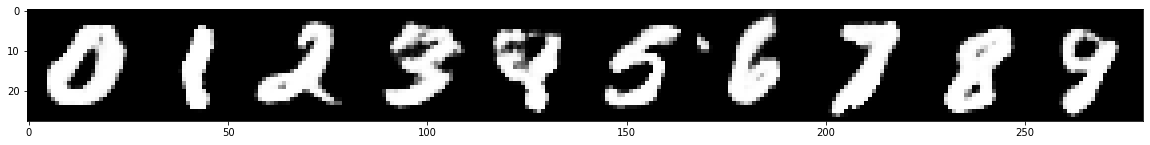

1094/1094 [==============================] - 17s 16ms/step - g_loss: 0.7717 - d_loss: 0.6733
Epoch 18/50
1091/1094 [============================>.] - ETA: 0s - g_loss: 0.7943 - d_loss: 0.6568

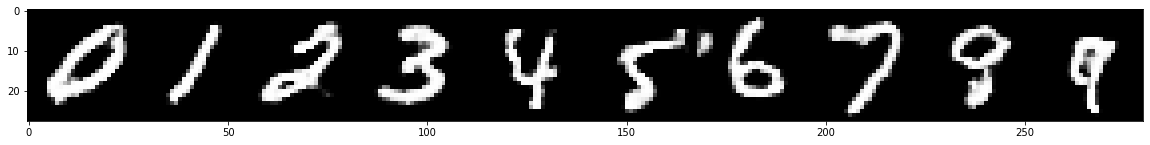

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7942 - d_loss: 0.6569
Epoch 19/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7900 - d_loss: 0.6565

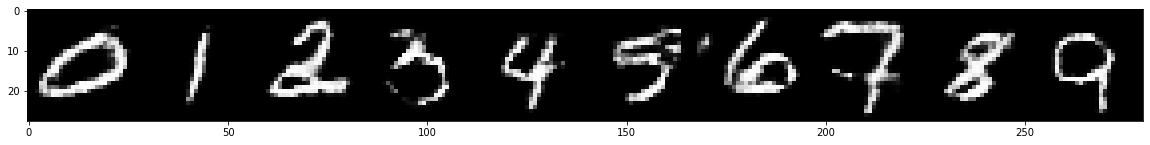

1094/1094 [==============================] - 17s 16ms/step - g_loss: 0.7900 - d_loss: 0.6564
Epoch 20/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7939 - d_loss: 0.6551

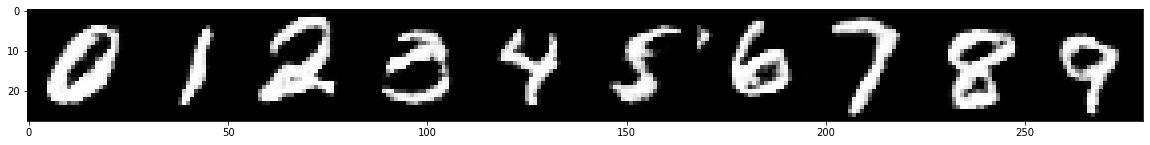

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7939 - d_loss: 0.6550
Epoch 21/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.8223 - d_loss: 0.6438

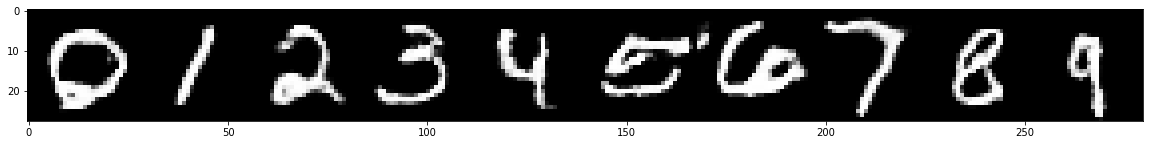

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8223 - d_loss: 0.6437
Epoch 22/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.8317 - d_loss: 0.6330

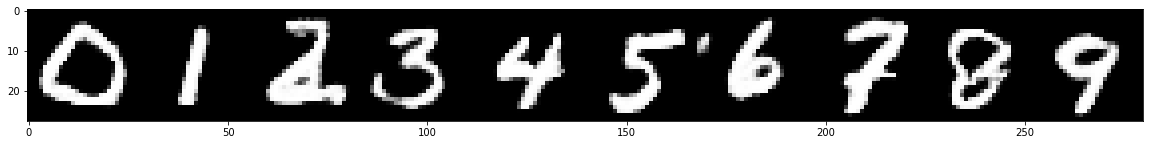

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8317 - d_loss: 0.6330
Epoch 23/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.8454 - d_loss: 0.6266

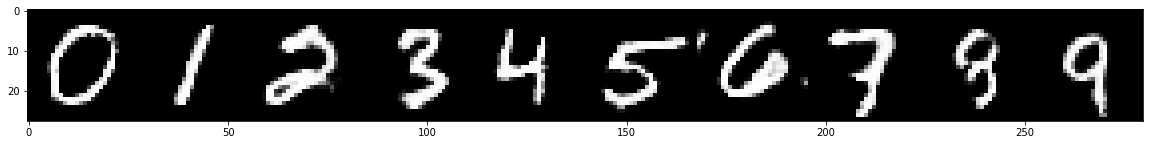

1094/1094 [==============================] - 18s 17ms/step - g_loss: 0.8454 - d_loss: 0.6266
Epoch 24/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.8374 - d_loss: 0.6293

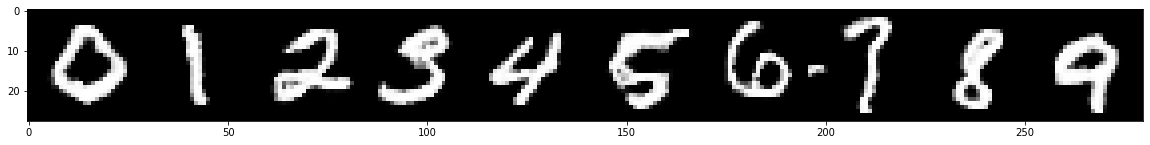

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8374 - d_loss: 0.6293
Epoch 25/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.8287 - d_loss: 0.6332

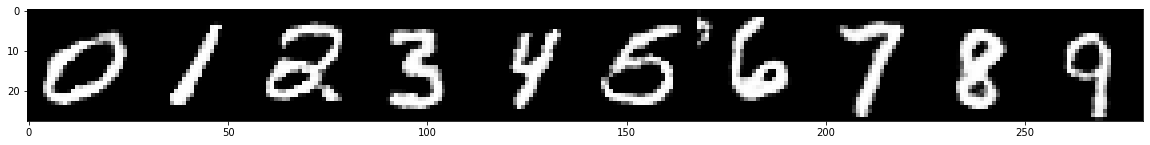

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8287 - d_loss: 0.6332
Epoch 26/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.8192 - d_loss: 0.6372

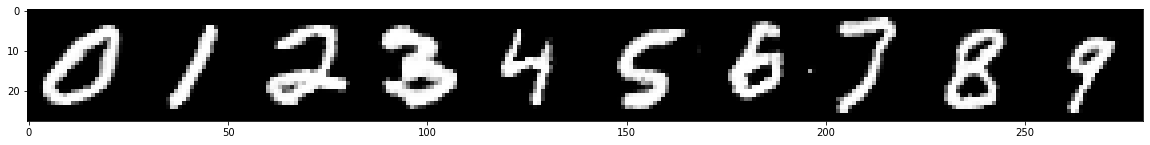

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8192 - d_loss: 0.6372
Epoch 27/50
1094/1094 [==============================] - ETA: 0s - g_loss: 0.8122 - d_loss: 0.6431

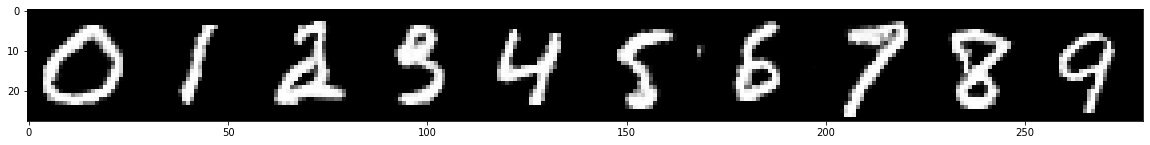

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8122 - d_loss: 0.6431
Epoch 28/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.8069 - d_loss: 0.6469

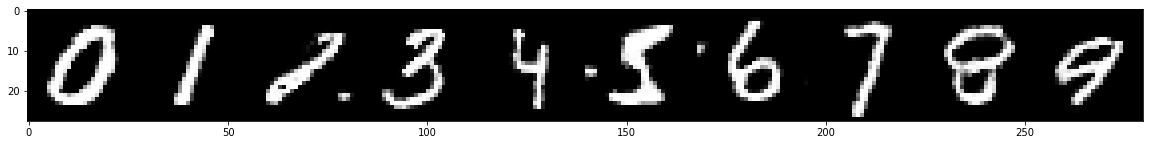

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.8069 - d_loss: 0.6469
Epoch 29/50
1094/1094 [==============================] - ETA: 0s - g_loss: 0.7961 - d_loss: 0.6548

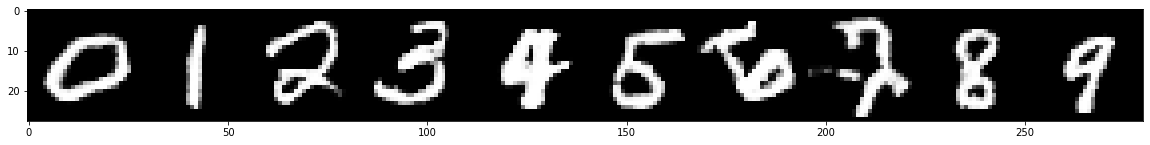

1094/1094 [==============================] - 17s 16ms/step - g_loss: 0.7961 - d_loss: 0.6548
Epoch 30/50
1091/1094 [============================>.] - ETA: 0s - g_loss: 0.7919 - d_loss: 0.6580

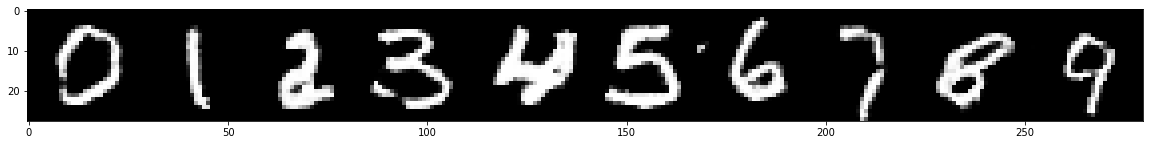

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7919 - d_loss: 0.6580
Epoch 31/50
1091/1094 [============================>.] - ETA: 0s - g_loss: 0.7875 - d_loss: 0.6617

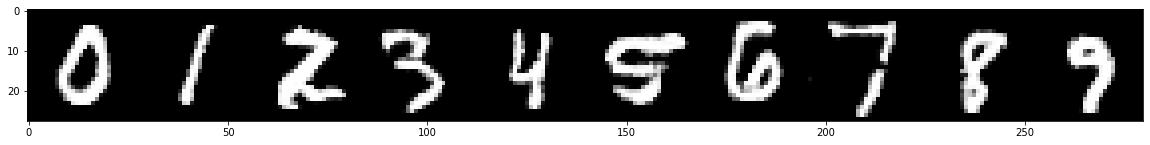

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7875 - d_loss: 0.6617
Epoch 32/50
1094/1094 [==============================] - ETA: 0s - g_loss: 0.7816 - d_loss: 0.6655

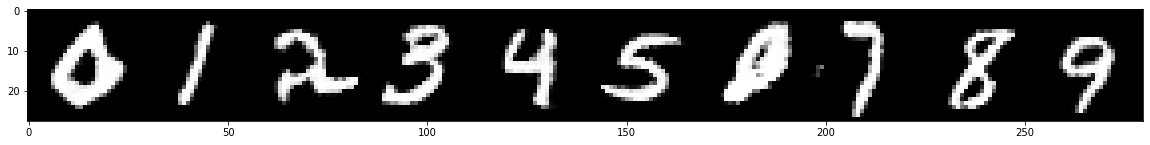

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7816 - d_loss: 0.6655
Epoch 33/50
1091/1094 [============================>.] - ETA: 0s - g_loss: 0.7764 - d_loss: 0.6658

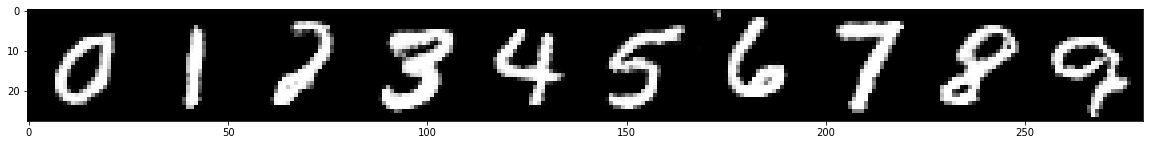

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7764 - d_loss: 0.6658
Epoch 34/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7675 - d_loss: 0.6686

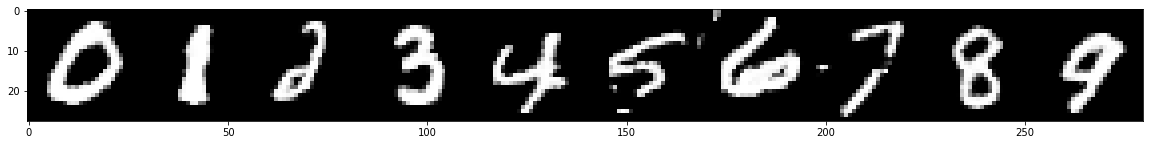

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7675 - d_loss: 0.6686
Epoch 35/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7679 - d_loss: 0.6703

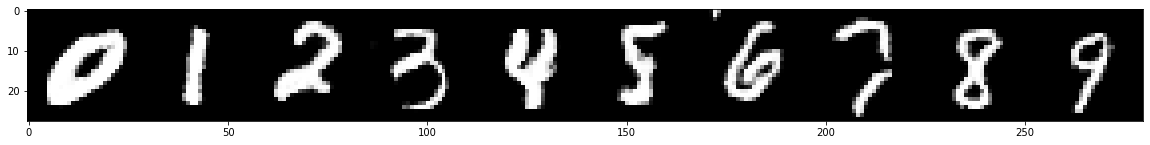

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7679 - d_loss: 0.6703
Epoch 36/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7683 - d_loss: 0.6716

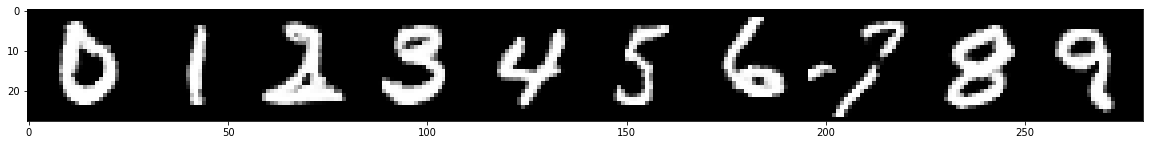

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7683 - d_loss: 0.6716
Epoch 37/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7635 - d_loss: 0.6726

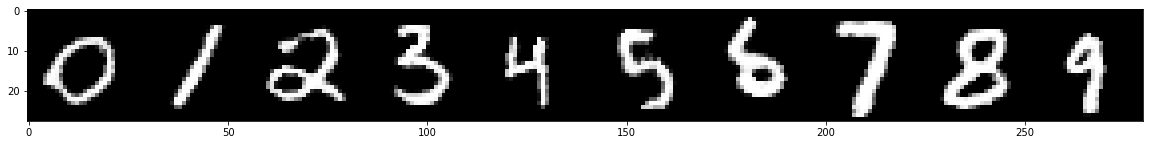

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7635 - d_loss: 0.6726
Epoch 38/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.7581 - d_loss: 0.6742

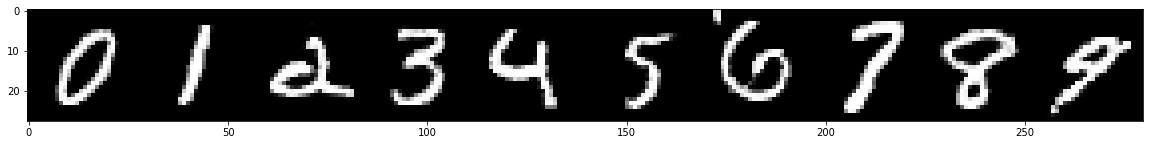

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7581 - d_loss: 0.6742
Epoch 39/50
1094/1094 [==============================] - ETA: 0s - g_loss: 0.7569 - d_loss: 0.6749

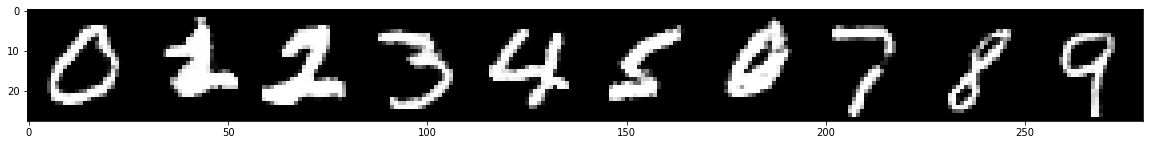

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7569 - d_loss: 0.6749
Epoch 40/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7556 - d_loss: 0.6751

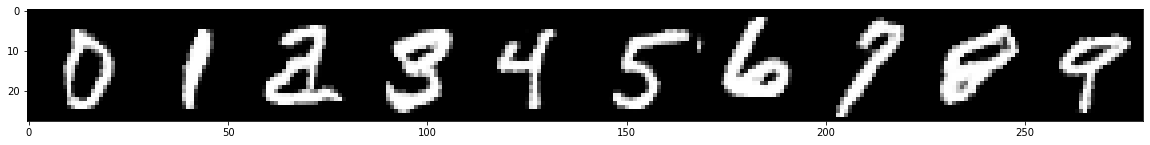

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7556 - d_loss: 0.6751
Epoch 41/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.7552 - d_loss: 0.6760

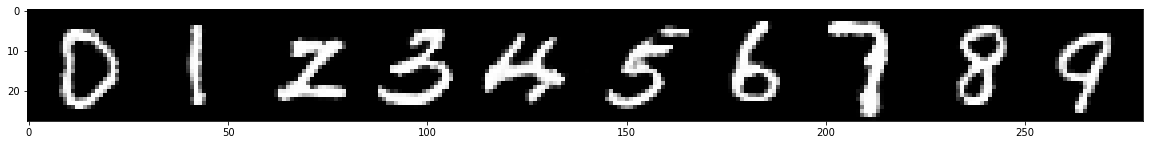

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7552 - d_loss: 0.6760
Epoch 42/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7502 - d_loss: 0.6777

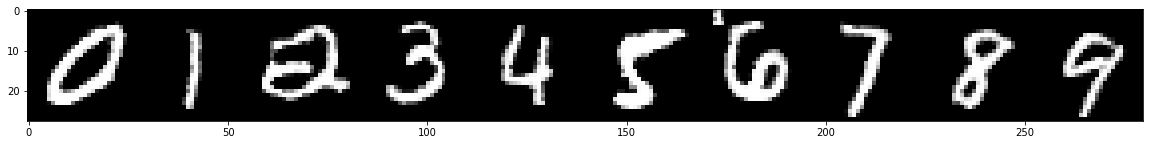

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7502 - d_loss: 0.6777
Epoch 43/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.7507 - d_loss: 0.6757

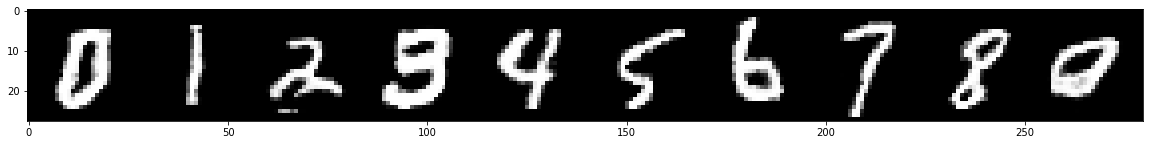

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7507 - d_loss: 0.6757
Epoch 44/50
1091/1094 [============================>.] - ETA: 0s - g_loss: 0.7502 - d_loss: 0.6776

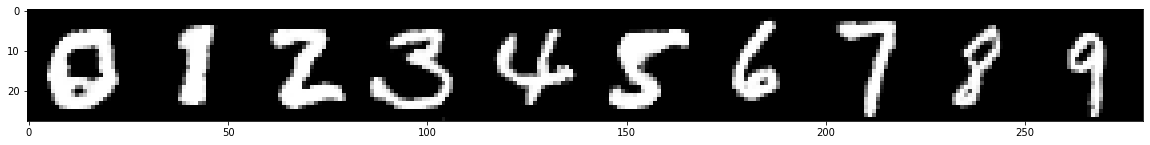

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7502 - d_loss: 0.6776
Epoch 45/50
1094/1094 [==============================] - ETA: 0s - g_loss: 0.7508 - d_loss: 0.6769

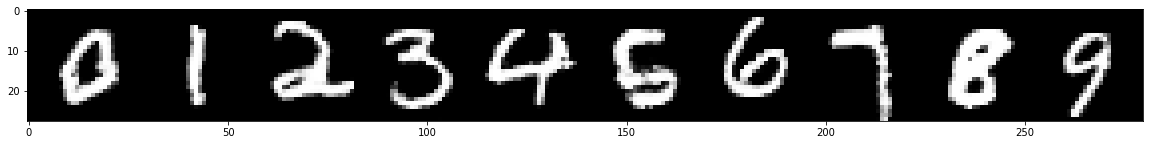

1094/1094 [==============================] - 17s 16ms/step - g_loss: 0.7508 - d_loss: 0.6769
Epoch 46/50
1093/1094 [============================>.] - ETA: 0s - g_loss: 0.7491 - d_loss: 0.6783

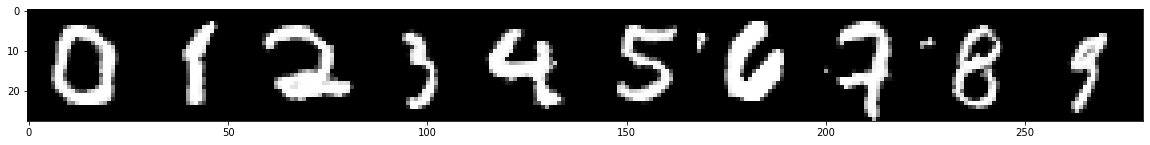

1094/1094 [==============================] - 17s 16ms/step - g_loss: 0.7491 - d_loss: 0.6783
Epoch 47/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.7457 - d_loss: 0.6788

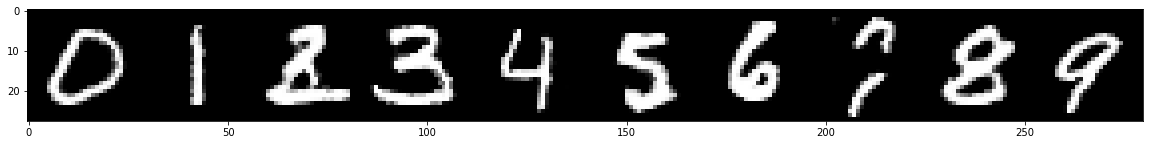

1094/1094 [==============================] - 17s 16ms/step - g_loss: 0.7457 - d_loss: 0.6788
Epoch 48/50
1094/1094 [==============================] - ETA: 0s - g_loss: 0.7424 - d_loss: 0.6798

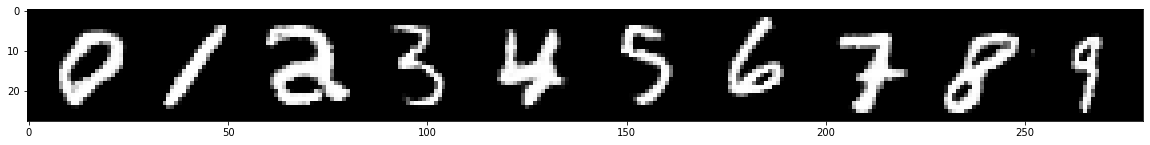

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7424 - d_loss: 0.6798
Epoch 49/50
1092/1094 [============================>.] - ETA: 0s - g_loss: 0.7428 - d_loss: 0.6787

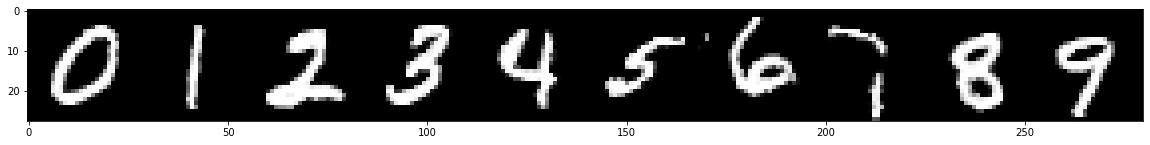

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7428 - d_loss: 0.6787
Epoch 50/50
1091/1094 [============================>.] - ETA: 0s - g_loss: 0.7443 - d_loss: 0.6792

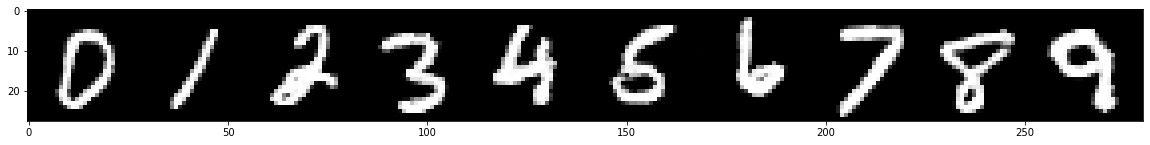

1094/1094 [==============================] - 18s 16ms/step - g_loss: 0.7443 - d_loss: 0.6792


In [9]:
EPOCHS = 151 
fit(dataset, EPOCHS)

## Load Weights and Show Results

In [22]:
checkpoint = tf.train.Checkpoint(d_optimizer=d_optimizer,
                                 g_optimizer=g_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)


In [23]:
checkpoint.restore(manager.latest_checkpoint)

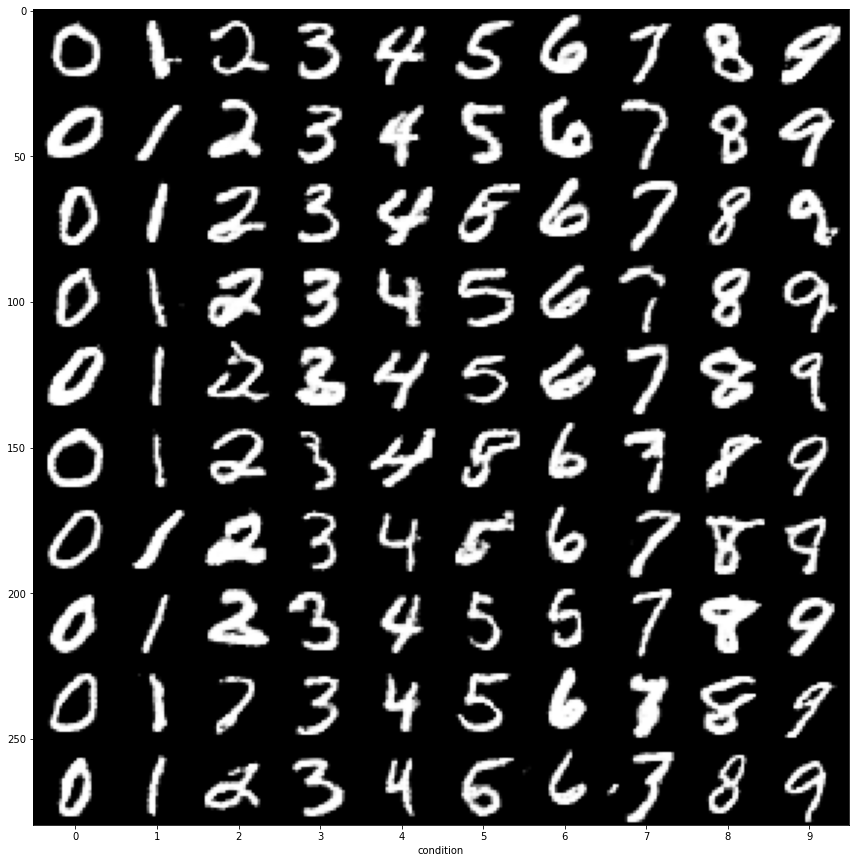

In [13]:
def plot_latent_space(gan, latent_dim, figsize=15):
    n=10
    # labels 
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    one_hot_labels = keras.utils.to_categorical(labels, 10)
    
    # display a n*n 2D manifold of digits
    digit_size = image_size
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        random_latent_vectors = tf.random.normal(shape=(n, latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1)
        digits = gan.generator(random_vector_labels)
        for j, xi in enumerate(grid_x):
            d = digits[j].numpy().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = d

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, labels)
    plt.xlabel("condition")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(checkpoint, latent_dim)
